In [2]:
import os
import sys
import psycopg2
import numpy as np
import fitsio
from astropy.table import Table, vstack, Column
import astropy.io.ascii
import re
from glob import glob
from datetime import date, timedelta
from scipy import optimize
from scipy.optimize import minimize
import contextlib

from desimeter.util import parse_fibers
from desimeter.dbutil import dbquery,get_petal_ids,get_pos_ids,get_petal_loc

from desimeter.transform.pos2ptl import int2ptl, ptl2flat
from desimeter.posparams.posmoveselection import posmove_selection
from desimeter.circles import fit_circle, _fast_fit_circle
from desimeter.transform.ptl2fp import fp2ptl


import matplotlib.pyplot as plt
%pylab inline

# The petal DB tables are by index number, but we refer to fibers by location
petal_id2loc = {4:0, 5:1, 6:2, 3:3, 8:4, 10:5, 11:6, 2:7, 7:8, 9:9}

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Helper functions for parsing the tables
re_phi_arc = re.compile('phi arc')
re_theta_arc = re.compile('theta arc')

def parse_int(string):
    if string == None: return 0
    else: return int(string)
def parse_float(string):
    if string == None: return 0
    else: return float(string)

In [4]:
# Connect to the database
args = {'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}
print(args)

comm = psycopg2.connect(host=args['host'],port=args['port'], database='desi_dev', user='desi_reader',password=args['password'])

{'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}


In [5]:
# present_cals = astropy.io.ascii.read('present_cals.ecsv',format='ecsv')
# cals = astropy.io.ascii.read('cals68442.ecsv',format='ecsv')
# new_cals = astropy.io.ascii.read('new_cals68442.ecsv',format='ecsv')
# m = fitsio.FITS('moves68442.fits.gz')

present_cals = astropy.io.ascii.read('present_cals95734.ecsv',format='ecsv')
cals = astropy.io.ascii.read('cals95734.ecsv',format='ecsv')
new_cals = astropy.io.ascii.read('new_cals95734.ecsv',format='ecsv')
m = fitsio.FITS('moves95734.fits.gz')

new_cals2 = astropy.io.ascii.read('new_cals68442.ecsv',format='ecsv')

moves = Table(m[1].read())

In [6]:
pos2idx = {pos_id:idx for idx,pos_id in enumerate(cals["pos_id"])}

In [7]:
def plot_fiber(fib, axsub=False, savefig=False):
    if not axsub: 
        fig,ax = plt.subplots(1,gridspec_kw=dict(hspace=0.2),figsize=(4,4))
        with np.printoptions(precision=3,suppress=True):
            new_cals[(new_cals['pos_id']==fib)].pprint_all()    
    else:
        ax = axsub
    f = moves[(moves['pos_id']==fib)]
    phi_arc = np.where(list([re_phi_arc.search(x) for x in f['log_note'] ]),True,False)
    theta_arc = np.where(list([re_theta_arc.search(x) for x in f['log_note'] ]),True,False)
    #fit_circle(f['X_FP'][theta_arc], f['Y_FP'][theta_arc])
    ax.scatter(f['obs_x'], f['obs_y'],s=8)
    ax.scatter(f['obs_x'][theta_arc], f['obs_y'][theta_arc], s=20, color='m')
    ax.scatter(f['obs_x'][phi_arc], f['obs_y'][phi_arc], s=20, color='r')
    xm = np.median(f['obs_x'][theta_arc])
    ym = np.median(f['obs_y'][theta_arc])
    s = 6
    if np.isfinite(xm) and np.isfinite(ym):
        ax.set_xlim([xm-s,xm+s])
        ax.set_ylim([ym-s,ym+s])
    #plt.axis('equal')
    ax.set_title(fib)
    if not axsub: 
        if savefig: plt.savefig(f'FPcalib_{fib:s}.png')
        plt.show()

def plot_many_fibers(c):
    # Give a selection of a cals table, with pos_id
    tot = len(c)
    print("Plotting", tot,"fibers")
    for n in range(0,tot,3):
        fig,ax = plt.subplots(1,3,gridspec_kw=dict(hspace=0.2),figsize=(14,4))
        plot_fiber(c[n]['pos_id'], axsub=ax[0])
        if n+1<tot: plot_fiber(c[n+1]['pos_id'], axsub=ax[1])
        if n+2<tot: plot_fiber(c[n+2]['pos_id'], axsub=ax[2])
        plt.show()

In [8]:
def test_fiber(pos_id):
    pass
    #fit_arcs(pos_id, moves, cals, new_cals, pos2idx[pos_id], diag=True)

test_fiber('M02518')

In [9]:
print(f'{len(new_cals):4d} total fibers')
broken = (cals['fiber_intact']==False)|(new_cals['arc_t']<-8.5)|(new_cals['arc_p']<-8.5)
print(f'{np.sum(broken):4d} broken/disabled fibers (including sky fibers)')
no_theta = (new_cals['arc_t']<-7.5)&~broken
no_phi = (new_cals['arc_p']<-7.5)&~broken
print(f'{np.sum(no_theta):4d} theta not moving')
print(f'{np.sum(no_phi):4d} phi not moving')
absent = broken|no_theta|no_phi
print(f'{np.sum(absent):4d} total of the above\n')

poor_theta = (new_cals['arc_t']<100)&(new_cals['nfit_t']<12)&~no_theta&~broken
poor_phi = (new_cals['err.length_r2']>0.035)|(new_cals['arc_p']<30)
poor_phi = poor_phi&~no_phi&~broken
print(f"{np.sum(poor_theta):4d} theta arc worked poorly (angle quite short or fit failed)")
print(f"{np.sum(poor_phi):4d} phi arc worked poorly (angle quite short or fit failed)")

bad = poor_theta|poor_phi|no_theta|no_phi|broken
usable = ~bad
print(f"{np.sum(bad):4d} total unusable calibrations")
print(f"{np.sum(usable):4d} total usable calibrations\n")

# Shorthand
# use = (new_cals['arc_t']>0)&((new_cals['arc_t']>100)|(new_cals['nfit_t']>12))&(new_cals['arc_p']>30)&(new_cals['err.length_r2']<0.035)

#linear_theta = (new_cals['arc_t']<300)&~no_theta&~broken
#linear_phi = (new_cals['arc_p']<60)&~no_phi&~broken
linear_theta = (new_cals['arc_t']<310)&(new_cals['median_angstep_t']<28)&~no_theta&~broken
linear_phi = (new_cals['arc_p']<12*9.5)&(new_cals['median_angstep_p']<9.5)&~no_phi&~broken
print(f"{np.sum(linear_theta):4d} irregular theta arcs (short & slow)")
print(f"{np.sum(linear_phi):4d} irregular phi arcs (shrt & slow)\n")

usable_xy = ~(poor_theta|broken|no_theta)&(new_cals['err.offset_xy']<0.006)
print(f"{np.sum(usable_xy)} acceptable XY centerings")
usable_r2 = ~(poor_phi|broken|no_phi)&(new_cals['err.length_r2']<0.03)
print(f"{np.sum(usable_r2)} acceptable R2 lengths")
print(f"{np.sum(usable_r2&usable_xy)} acceptable calibs\n")

good = usable&(new_cals['err.offset_xy']<0.004)&(new_cals['err.length_r2']<0.015)
print(f"{np.sum(good):4d} total good calibrations\n")

enabled = (present_cals['device_classified_nonfunctional']==False)
print(f"{np.sum(enabled):4d} presently enabled positioners")
print(f"{np.sum(enabled&~usable):4d} lack usable calibration")
print(f"{np.sum(enabled&~(usable&usable_xy&usable_r2)):4d} lack acceptable calibration")
print(f"{np.sum(enabled&~good):4d} lack good calibration")



5020 total fibers
 175 broken/disabled fibers (including sky fibers)
   6 theta not moving
   6 phi not moving
 186 total of the above

   5 theta arc worked poorly (angle quite short or fit failed)
   6 phi arc worked poorly (angle quite short or fit failed)
 196 total unusable calibrations
4824 total usable calibrations

 166 irregular theta arcs (short & slow)
 299 irregular phi arcs (shrt & slow)

4829 acceptable XY centerings
4831 acceptable R2 lengths
4817 acceptable calibs

4728 total good calibrations

4191 presently enabled positioners
   1 lack usable calibration
   1 lack acceptable calibration
  12 lack good calibration


In [19]:
# These are fibers that appear to not be working in theta.
# So there is no point in trying to reactivate them to try to comb them.
bad_p6 = (present_cals['petal_id']==11)&( (present_cals['bus_id']=='can10') |(present_cals['bus_id']=='can17'))
print("Excluding from petal 6:", np.sum(bad_p6))

sky = (present_cals['device_loc']==461)|(present_cals['device_loc']==501)
sel = (broken|no_theta)&~bad_p6&~sky
# Add in M02866, based on inspection of that plot
sel = sel | (new_cals['pos_id']=='M02866')
print(np.sum(sel))
c = new_cals[sel]
print(' '.join(c['pos_id']))
#print(list(c['pos_id']))
pc = present_cals[sel]

Excluding from petal 6: 77
87
M01133 M01276 M01282 M01482 M01690 M01719 M01764 M01956 M02060 M02065 M02351 M02433 M02480 M02547 M02582 M02668 M02809 M02866 M02905 M03120 M03232 M03294 M03409 M03415 M03454 M03456 M03493 M03545 M03554 M03596 M03599 M03601 M03672 M03757 M03802 M03809 M03837 M03966 M03972 M04060 M04083 M04138 M04217 M04235 M04243 M04316 M04386 M04556 M04569 M04585 M04588 M04596 M04711 M04712 M04722 M04744 M04763 M04792 M04980 M05018 M05038 M05066 M05152 M05300 M05439 M05445 M05472 M05478 M05506 M05515 M05638 M05675 M05797 M05970 M06489 M06783 M07119 M07163 M07369 M07373 M07416 M07480 M07500 M07638 M07733 M07763 M07863


In [9]:
sel = ~(poor_theta|broken|no_theta)&~usable
print(usable_xy[sel])
#new_cals[sel]

[ True  True  True  True  True  True  True  True  True  True]


**Create a calibration file**

We want to impose the 'usable' calibrations.  We might want impose the XY centers for cases with poor_phi.

Separately, we should mark the pos_ok set as functional and un-retracted.

Separately, we should take the nonfunctional positioners that have phi<160 and make them un-retracted (get rid of the circular keepout).

In [10]:
recal = new_cals[usable]
for col in recal.keys():
    recal.rename_column(col, col.upper())
recal.add_column(np.full(len(recal), True, dtype=bool), index=2, name='COMMIT_LENGTH_R1')
recal.add_column(np.full(len(recal), True, dtype=bool), index=4, name='COMMIT_LENGTH_R2')
recal.add_column(np.full(len(recal), True, dtype=bool), index=6, name='COMMIT_OFFSET_X')
recal.add_column(np.full(len(recal), True, dtype=bool), index=8, name='COMMIT_OFFSET_Y')

def check_bounds(val, low, up):
    print(np.sum((val<low)), np.sum((val>up)))

# Do a final check -- 
print("These checks should be 0")
check_bounds(recal['LENGTH_R1'],2.0,4.0)
check_bounds(recal['LENGTH_R2'],2.5,3.5)
print(np.sum((recal['OFFSET_X']==0)))
print(np.sum((recal['OFFSET_Y']==0)))
check_bounds(recal['OFFSET_X']-present_cals['offset_x'][usable], -1.0, 1.0)
check_bounds(recal['OFFSET_Y']-present_cals['offset_y'][usable], -1.0, 1.0)

log_note = [f"Calib from 20210623 arcs: {c['ERR.LENGTH_R2']*1000.0:4.2f} um R2 error; {c['ERR.OFFSET_XY']*1000.0:4.2f} um XY error. Theta {c['ARC_T']:5.2f} deg; {c['RMS_T']*1000.0:4.2f} um rms; {c['NFIT_T']} pts; {c['MEDIAN_ANGSTEP_T']:4.2f} deg median step. Phi {c['ARC_P']:5.2f} deg; {c['RMS_P']*1000.0:4.2f} um rms; {c['NFIT_P']} pts; {c['MEDIAN_ANGSTEP_P']:4.2f} deg median step." \
            for c in recal]

recal.add_column(log_note, index=9, name='ENABLE_DISABLE_RATIONALE')

astropy.io.ascii.write(recal,'recalibration_95734.ecsv',format='ecsv')
astropy.io.ascii.write(recal,'recalibration_95734.csv',format='csv')

recal[(recal['LENGTH_R1']<2.5)|(recal['LENGTH_R1']>3.5)]

These checks should be 0
0 0
0 0
0
0
0 0
0 0


POS_ID,LENGTH_R1,COMMIT_LENGTH_R1,LENGTH_R2,COMMIT_LENGTH_R2,OFFSET_X,COMMIT_OFFSET_X,OFFSET_Y,COMMIT_OFFSET_Y,ENABLE_DISABLE_RATIONALE,ARC_T,ARC_P,RMS_T,RMS_P,ERR.LENGTH_R2,ERR.OFFSET_XY,NFIT_T,NFIT_P,NPRUNE_T,NPRUNE_P,THETA_ARC_RADIUS,THETA_ARC_PHI,MEDIAN_ANGSTEP_T,MEDIAN_ANGSTEP_P,RMS_ANGSTEP_T,RMS_ANGSTEP_P,MAX_P
str6,float32,bool,float32,bool,float32,bool,float32,bool,str189,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M02128,3.7257,True,3.1139,True,288.9607,True,167.8023,True,Calib from 20210623 arcs: 2.00 um R2 error; 1.10 um XY error. Theta 329.86 deg; 2.80 um rms; 15.0 pts; 29.99 deg median step. Phi 120.22 deg; 2.30 um rms; 21.0 pts; 10.01 deg median step.,329.8633,120.2161,0.0028,0.0023,0.0020,0.0011,15,21,0,0,3.0934,127.1373,29.9912,10.0131,0.1683,0.1584,179.4303
M03944,2.4232,True,3.0689,True,373.3760,True,149.7284,True,Calib from 20210623 arcs: 2.40 um R2 error; 1.40 um XY error. Theta 329.72 deg; 3.40 um rms; 15.0 pts; 30.02 deg median step. Phi 120.64 deg; 2.90 um rms; 21.0 pts; 10.03 deg median step.,329.7198,120.6385,0.0034,0.0029,0.0024,0.0014,15,21,0,0,2.6553,123.6399,30.0160,10.0301,0.0845,0.7113,176.6835
M06345,2.1418,True,3.0249,True,304.4928,True,122.6332,True,Calib from 20210623 arcs: 3.10 um R2 error; 0.90 um XY error. Theta 330.13 deg; 2.20 um rms; 15.0 pts; 30.06 deg median step. Phi 120.22 deg; 3.60 um rms; 21.0 pts; 10.00 deg median step.,330.1314,120.2212,0.0022,0.0036,0.0031,0.0009,15,21,0,0,1.6957,146.9573,30.0649,9.9960,0.2930,0.1142,177.0891


In [11]:
# Perhaps there are some positioners that performed well in this calibration?
pos_ok = (present_cals['device_classified_nonfunctional']==True)&(present_cals['fiber_intact']==True)
print("Non-functional but intact", np.sum(pos_ok))
pos_ok = pos_ok&(new_cals['arc_t']>320)&(np.abs(new_cals['median_angstep_t']-30)<0.1)
print("+Theta performed", np.sum(pos_ok))
pos_ok = pos_ok&(new_cals['arc_p']>90)&(np.abs(new_cals['median_angstep_p']-10)<0.06)
print("+Phi performed", np.sum(pos_ok))
pos_ok = pos_ok&(new_cals['rms_t']<0.005)&(new_cals['rms_p']<0.005)
print("+RMS looks good", np.sum(pos_ok))
pos_ok = pos_ok&(new_cals['err.length_r2']<0.025)&(new_cals['err.offset_xy']<0.005)
print("+Calib Errs looks good", np.sum(pos_ok))
pos_ok = pos_ok&(present_cals['petal_id']!=11)
print("+Exclude Petal 6:", np.sum(pos_ok))
pos_ok = pos_ok&(new_cals['length_r1']>2.5)&(new_cals['length_r1']<3.5)
print("+Exclude Petal 6:", np.sum(pos_ok))

Non-functional but intact 790
+Theta performed 430
+Phi performed 125
+RMS looks good 119
+Calib Errs looks good 119
+Exclude Petal 6: 116
+Exclude Petal 6: 113


In [12]:
# These positioners are candidates to turn on.
c = new_cals[pos_ok]
print(len(c))
print(' '.join(c['pos_id']))
print(list(c['pos_id']))
# bus_id = np.array([int(x[3:5]) for x in present_cals['bus_id']])
# petal_bus = np.array([petal_id2loc[x] for x in present_cals['petal_id']])*100+bus_id
# print(np.unique(petal_bus[pos_ok], return_counts=True))

# plt.hist(c['median_angstep_t']+20, bins=80)
# plt.show()
#plot_many_fibers(c)
#present_cals[pos_ok].show_in_notebook()
#c.show_in_notebook()

113
M01065 M01237 M01494 M01502 M01635 M01722 M01916 M02251 M02265 M02284 M02437 M02467 M02629 M02640 M02701 M02708 M02712 M02720 M02731 M02747 M02763 M02841 M02855 M02883 M02899 M03009 M03084 M03092 M03099 M03104 M03126 M03137 M03230 M03278 M03290 M03293 M03321 M03357 M03361 M03416 M03427 M03446 M03469 M03478 M03528 M03570 M03581 M03624 M03625 M03631 M03651 M03659 M03697 M03698 M03712 M03730 M03749 M03892 M03901 M03953 M04009 M04064 M04081 M04112 M04127 M04161 M04381 M04452 M04493 M04515 M04606 M04607 M04635 M04641 M04661 M04667 M04702 M04883 M04915 M05027 M05041 M05078 M05291 M05398 M05470 M05616 M05622 M05780 M05809 M05836 M05982 M06185 M06353 M06695 M06736 M06757 M06764 M06913 M06942 M06964 M07022 M07073 M07110 M07216 M07223 M07241 M07264 M07403 M07504 M07588 M07710 M08097 M08190
['M01065', 'M01237', 'M01494', 'M01502', 'M01635', 'M01722', 'M01916', 'M02251', 'M02265', 'M02284', 'M02437', 'M02467', 'M02629', 'M02640', 'M02701', 'M02708', 'M02712', 'M02720', 'M02731', 'M02747', 'M02

113 103 passed the XY test
5020 5020
77 moved fully in Dec
['M01065', 'M01237', 'M01494', 'M01502', 'M01635', 'M01722', 'M01916', 'M02251', 'M02265', 'M02284', 'M02437', 'M02629', 'M02640', 'M02701', 'M02708', 'M02731', 'M02855', 'M02883', 'M02899', 'M03278', 'M03290', 'M03357', 'M03361', 'M03416', 'M03528', 'M03581', 'M03624', 'M03625', 'M03631', 'M03697', 'M03698', 'M03730', 'M03749', 'M03892', 'M03901', 'M03953', 'M04009', 'M04081', 'M04112', 'M04127', 'M04381', 'M04452', 'M04606', 'M04607', 'M04667', 'M04702', 'M04883', 'M05027', 'M05041', 'M05078', 'M05291', 'M05470', 'M05616', 'M05622', 'M05780', 'M05809', 'M05982', 'M06185', 'M06353', 'M06695', 'M06736', 'M06757', 'M06764', 'M06913', 'M06942', 'M07022', 'M07073', 'M07110', 'M07216', 'M07223', 'M07241', 'M07264', 'M07403', 'M07504', 'M07710', 'M08097', 'M08190']
26 may have moved badly in Dec
['M02712', 'M02747', 'M02763', 'M03009', 'M03084', 'M03092', 'M03104', 'M03126', 'M03230', 'M03293', 'M03321', 'M03427', 'M03446', 'M03469'

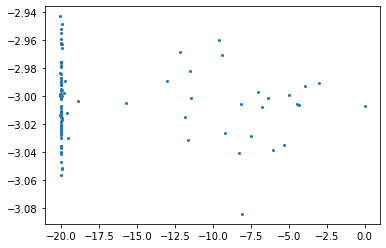

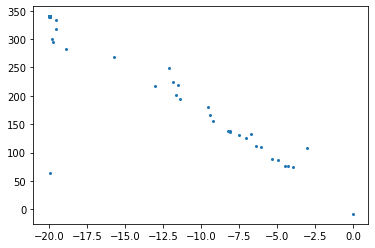

In [23]:
# These positioners did poorly on the XY test on June 25
failed_xy = ['M02720', 'M02841', 'M03099', 'M04661', \
'M02467', 'M03137', 'M04064', 'M04641', 'M04915', 'M06813', 'M07588', 'M07934']
pos_ok_xy = pos_ok.copy()
for p in failed_xy: pos_ok_xy[pos2idx[p]] = False
print(np.sum(pos_ok), np.sum(pos_ok_xy), "passed the XY test")

cals_dec = Table.read("new_cals68442.ecsv")
print(len(cals_dec), np.sum((cals_dec['pos_id']==new_cals['pos_id'])))

#good_dec = (cals_dec['arc_t']>310)&(cals_dec['arc_p']>45)
good_dec = (np.abs(cals_dec['median_angstep_t']+20)<0.5)&(np.abs(cals_dec['median_angstep_p']+3)<0.3)

print(np.sum(pos_ok_xy&good_dec), "moved fully in Dec")
print(list(new_cals['pos_id'][pos_ok_xy&good_dec]))

print(np.sum(pos_ok_xy&~good_dec), "may have moved badly in Dec")
print(list(new_cals['pos_id'][pos_ok_xy&~good_dec]))

# It seems that the balky ones are all due to theta.
plt.scatter(cals_dec['median_angstep_t'][pos_ok_xy], cals_dec['median_angstep_p'][pos_ok_xy], s=4)
plt.show()

plt.scatter(cals_dec['median_angstep_t'][pos_ok_xy], cals_dec['arc_t'][pos_ok_xy], s=4)
plt.show()

**Plot aspects of the new calibrations**

4663


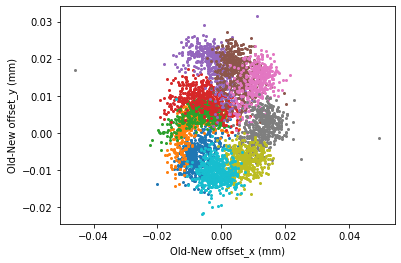

4719


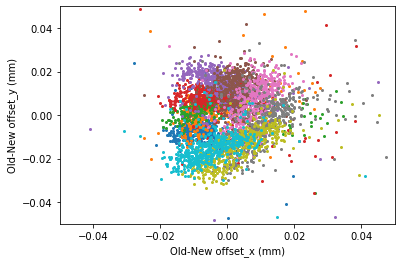

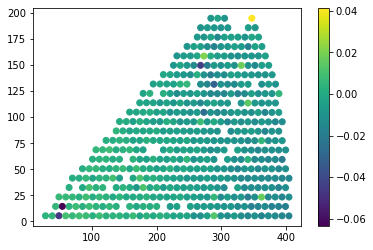

In [14]:
dx = new_cals2['offset_x']-new_cals['offset_x']
dy = new_cals2['offset_y']-new_cals['offset_y']
sel = (new_cals2['arc_t']>200)&(new_cals['arc_t']>200)
print(np.sum(sel))
for pid in petal_id2loc.keys():
    sel2 = sel&(present_cals['petal_id']==pid)
    plt.scatter(dx[sel2], dy[sel2],s=4)
plt.xlabel('Old-New offset_x (mm)')
plt.ylabel('Old-New offset_y (mm)')
plt.show()

dx = present_cals['offset_x']-new_cals['offset_x']
dy = present_cals['offset_y']-new_cals['offset_y']
sel = (new_cals['arc_t']>200)
print(np.sum(sel))
for pid in petal_id2loc.keys():
    sel2 = sel&(present_cals['petal_id']==pid)
    plt.scatter(dx[sel2], dy[sel2],s=4)
plt.xlabel('Old-New offset_x (mm)')
plt.ylabel('Old-New offset_y (mm)')
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.show()

# Plot across the last petal
plt.scatter(new_cals2['offset_x'][sel2], new_cals2['offset_y'][sel2], c=dx[sel2])
plt.colorbar()
plt.show()

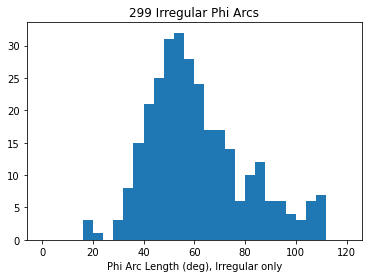

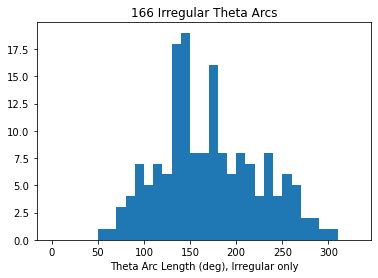

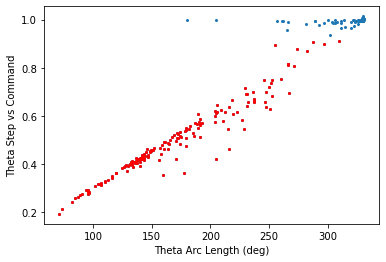

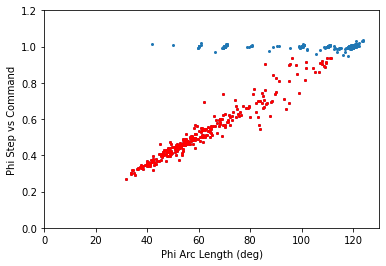

In [15]:
# linear_theta = (new_cals['arc_t']<310)&(new_cals['median_angstep_t']<28)&~no_theta&~broken
# linear_phi = (new_cals['arc_p']<12*9.5)&(new_cals['median_angstep_p']<9.5)&~no_phi&~broken

# print(np.sum(linear_theta))
# print(np.sum(linear_phi))

plt.hist(new_cals['arc_p'][linear_phi], range=[0,120], bins=30)
plt.xlabel("Phi Arc Length (deg), Irregular only")
plt.title(f"{np.sum(linear_phi)} Irregular Phi Arcs")
#plt.savefig("arc_phi.png")
plt.show()

plt.hist(new_cals['arc_t'][linear_theta], range=[0,330], bins=33)
plt.xlabel("Theta Arc Length (deg), Irregular only")
plt.title(f"{np.sum(linear_theta)} Irregular Theta Arcs")
#plt.savefig("arc_theta.png")
plt.show()

sel = usable
plt.scatter(new_cals['arc_t'][sel], new_cals['median_angstep_t'][sel]/30.0, s=4)
plt.scatter(new_cals['arc_t'][sel&linear_theta], new_cals['median_angstep_t'][sel&linear_theta]/30.0, s=4, color='r')

plt.xlabel("Theta Arc Length (deg)")
plt.ylabel("Theta Step vs Command")
#plt.savefig("arc_theta_command.png")
plt.show()
plt.scatter(new_cals['arc_p'][sel], new_cals['median_angstep_p'][sel]/10.0, s=4)
plt.scatter(new_cals['arc_p'][sel&linear_phi], new_cals['median_angstep_p'][sel&linear_phi]/10.0, s=4, color='r')

plt.xlabel("Phi Arc Length (deg)")
plt.ylabel("Phi Step vs Command")
plt.xlim([0,130])
plt.ylim([0,1.2])
#plt.savefig("arc_phi_command.png")
plt.show()

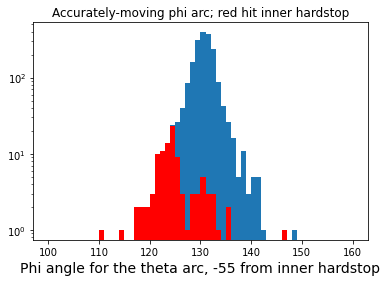

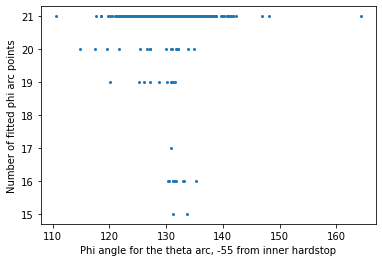

In [16]:
sel = usable&(np.abs(new_cals['median_angstep_p']-10)<0.02)
plt.hist(new_cals['theta_arc_phi'][sel],bins=60,range=[100,160])
plt.hist(new_cals['theta_arc_phi'][sel&(new_cals['max_p']<178)],bins=60,range=[100,160],color='r')
plt.xlabel("Phi angle for the theta arc, -55 from inner hardstop",size=14)
plt.title("Accurately-moving phi arc; red hit inner hardstop")
plt.semilogy()
#plt.savefig('arc_theta_arc_phi.png')
plt.show()

plt.scatter(new_cals['theta_arc_phi'][sel],new_cals['nfit_p'][sel], s=4)
plt.xlabel("Phi angle for the theta arc, -55 from inner hardstop")
plt.ylabel("Number of fitted phi arc points")
plt.show()

Offset_xy: [ 3.10105439  5.51670431  9.7327856  13.32967585 18.27251335 26.78131412
 51.18567494]


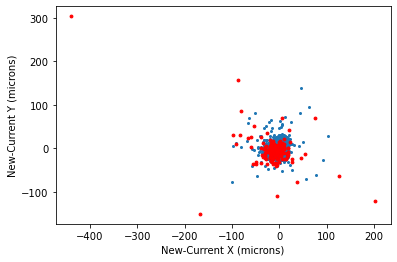

Length_r1: [-137.55404456  -25.200058     -9.60000057   -3.19993877    3.70001717
   23.9000552   167.31305236]
Length_r2: [-145.20903159  -22.46992487   -6.40003948    0.90006065    8.5999527
   34.3850355   208.80809076]


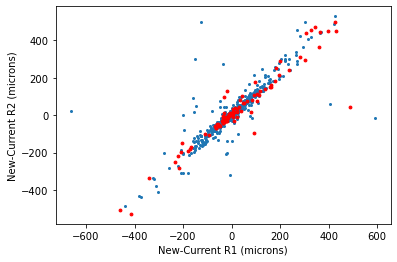

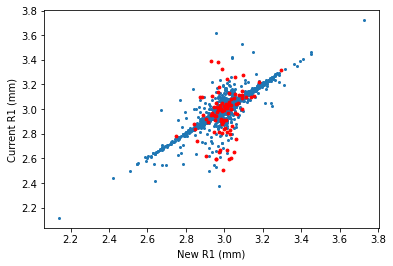

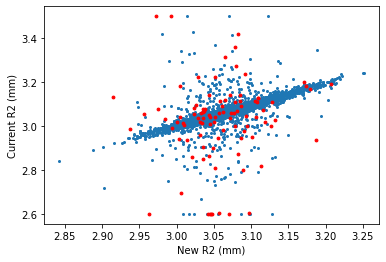

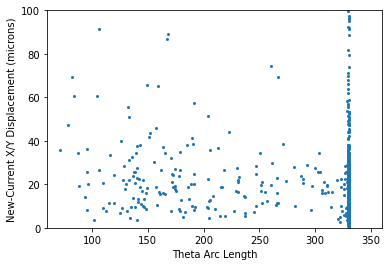

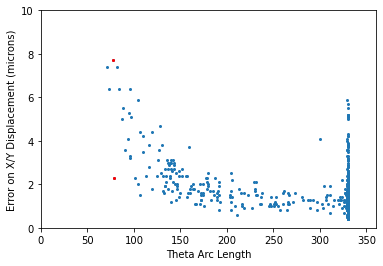

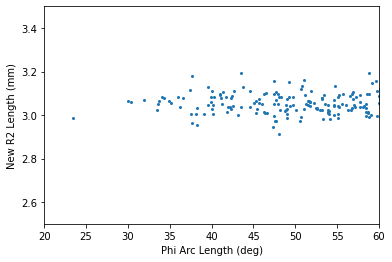

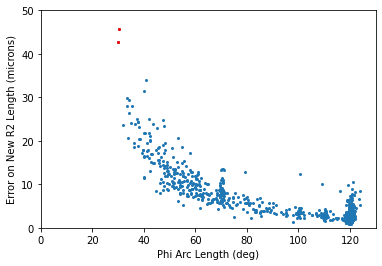

In [17]:
dx = (new_cals['offset_x']-present_cals['offset_x'])*1000
dy = (new_cals['offset_y']-present_cals['offset_y'])*1000
dr = np.sqrt(dx**2+dy**2)
print("Offset_xy:", np.quantile(dr[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
sel = (new_cals['arc_t']>300)
plt.scatter(dx[sel], dy[sel], s=4)
plt.scatter(dx[~sel&(new_cals['arc_t']>60)], dy[~sel&(new_cals['arc_t']>60)], s=8,color='r')
plt.xlabel('New-Current X (microns)')
plt.ylabel('New-Current Y (microns)')
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.2,0.2])
plt.show()

dx = (new_cals['length_r1']-present_cals['length_r1'])*1000
dy = (new_cals['length_r2']-present_cals['length_r2'])*1000
print("Length_r1:", np.quantile(dx[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
print("Length_r2:", np.quantile(dy[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
plt.scatter(dx[good], dy[good], s=4)
plt.scatter(dx[usable&~good], dy[usable&~good], s=8, color='r')
plt.xlabel('New-Current R1 (microns)')
plt.ylabel('New-Current R2 (microns)')
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.2,0.2])
plt.show()

plt.scatter(new_cals['length_r1'][good], present_cals['length_r1'][good], s=4)
plt.scatter(new_cals['length_r1'][usable&~good], present_cals['length_r1'][usable&~good], s=8, color='r')
plt.xlabel("New R1 (mm)")
plt.ylabel("Current R1 (mm)")
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.2,0.2])
plt.show()

plt.scatter(new_cals['length_r2'][good], present_cals['length_r2'][good], s=4)
plt.scatter(new_cals['length_r2'][usable&~good], present_cals['length_r2'][usable&~good], s=8, color='r')
plt.xlabel("New R2 (mm)")
plt.ylabel("Current R2 (mm)")
# plt.xlim([-0.2,0.2])
# plt.ylim([-0.2,0.2])
#plt.savefig("arc_r2comparison.png")
plt.show()

plt.scatter(new_cals['arc_t'],dr,s=4)
plt.xlim([60,360])
plt.ylim([0,100])
plt.xlabel("Theta Arc Length")
plt.ylabel("New-Current X/Y Displacement (microns)")
#plt.savefig("arc_theta_deltaoffset.png")
plt.show()

plt.scatter(new_cals['arc_t'],new_cals['err.offset_xy']*1000.0,s=4)
plt.scatter(new_cals['arc_t'][poor_theta],new_cals['err.offset_xy'][poor_theta]*1000.0,s=4,color='r')
plt.xlim([0,360])
plt.ylim([0,10])
plt.xlabel("Theta Arc Length")
plt.ylabel("Error on X/Y Displacement (microns)")
#plt.savefig("arc_theta_errxy.png")
plt.show()

plt.scatter(new_cals['arc_p'],new_cals['length_r2'],s=4)
plt.xlim([20,60])
plt.ylim([2.5,3.5])
plt.xlabel("Phi Arc Length (deg)")
plt.ylabel("New R2 Length (mm)")
plt.show()

plt.scatter(new_cals['arc_p'],new_cals['err.length_r2']*1000.0,s=4)
plt.scatter(new_cals['arc_p'][poor_phi],new_cals['err.length_r2'][poor_phi]*1000.0,s=4,color='r')
plt.xlim([0,130])
plt.ylim([0,50])
#plt.semilogy()
plt.xlabel("Phi Arc Length (deg)")
plt.ylabel("Error on New R2 Length (microns)")
#plt.savefig("arc_phi_errR2.png")
plt.show()

**Plot classes of positioners**

M01491 M01496 M02258 M03584 M03945 M03979
Plotting 6 fibers


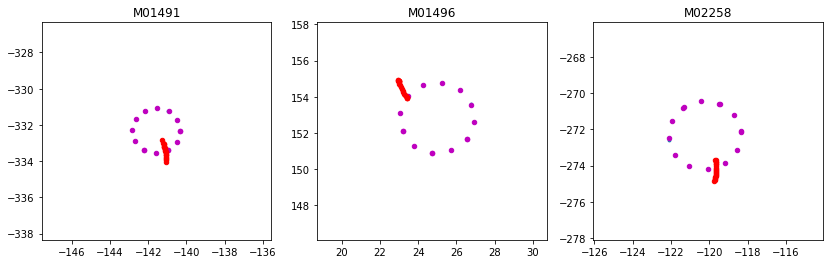

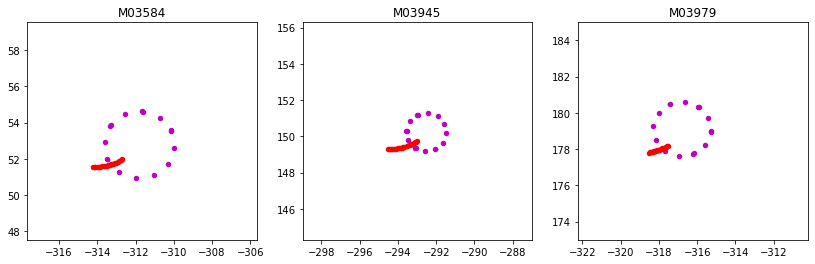

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M01491,2.9738,2.9872,310.1549,185.8874,329.8824,23.4427,0.0026,0.0025,0.0669,0.0011,15,21,0,0,1.2499,155.7938,29.9935,1.8663,0.1560,1.2104,168.4260
1,M01496,3.0642,3.1419,153.1182,23.3929,329.8736,19.4708,0.0023,0.0028,0.1216,0.0009,15,14,0,7,1.9388,143.6203,29.9624,1.5033,0.1283,0.5343,144.3884
2,M02258,3.4216,3.5090,257.4904,149.7893,329.7737,19.4467,0.0069,0.0028,0.1006,0.0029,15,21,0,0,1.8977,148.2489,30.0145,1.7926,0.3190,0.4529,155.7142
3,M03584,3.0658,3.0585,283.5929,140.6554,330.1065,30.3328,0.0036,0.0031,0.0458,0.0015,15,21,0,0,1.8414,145.0042,29.9726,2.8257,0.0959,0.7524,157.0677
4,M03945,2.9563,3.0631,325.3541,50.4064,329.8861,30.0714,0.0025,0.0029,0.0428,0.0010,15,21,0,0,1.0424,160.1586,29.9314,2.7050,0.2980,0.4777,166.9434
5,M03979,2.8984,3.1230,362.0787,41.3250,330.0297,19.7798,0.0020,0.0026,0.0927,0.0008,15,21,0,0,1.5018,151.4255,30.0201,1.8196,0.2093,0.3808,157.5828


In [18]:
# Here are the poor phi cases
c = new_cals[poor_phi] 
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

M02474 M02866 M04595 M05961 M07271
Plotting 5 fibers


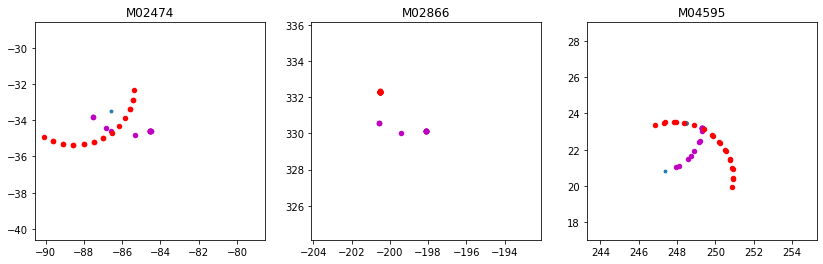

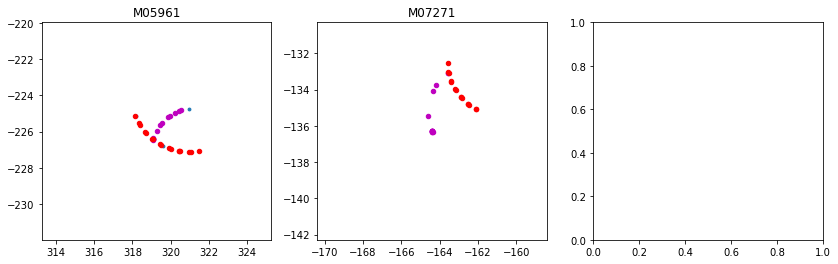

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M02474,2.9679,3.1067,85.4800,32.3352,78.4336,119.9111,0.0004,0.0013,0.0011,0.0023,5,21,10,0,2.4508,132.4799,29.7557,9.9767,0.0000,0.0634,180.7511
1,M02866,0.0000,0.0000,0.0000,0.0000,-5.0000,-8.0000,0.0000,0.0000,9.9900,0.0000,3,21,12,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,M04595,2.9818,3.0773,246.9458,23.2393,60.6966,119.0956,0.0029,0.0029,0.0025,0.0162,9,21,6,0,2.4974,131.3489,12.6158,10.0273,4.6701,0.4290,178.0762
3,M05961,2.9654,3.0440,393.9363,5.2134,55.5769,79.0256,0.0021,0.0028,0.0067,0.0128,10,17,5,0,2.3285,134.4275,10.6813,10.0564,3.7093,0.4826,183.1090
4,M07271,3.0390,2.9933,210.5484,14.2473,77.2933,58.7655,0.0016,0.0020,0.0089,0.0077,6,15,9,0,2.6658,127.5539,24.6903,9.9794,5.5788,0.4902,176.1687


In [19]:
# Here are the poor theta cases
c = new_cals[poor_theta]
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

M02866
Plotting 1 fibers


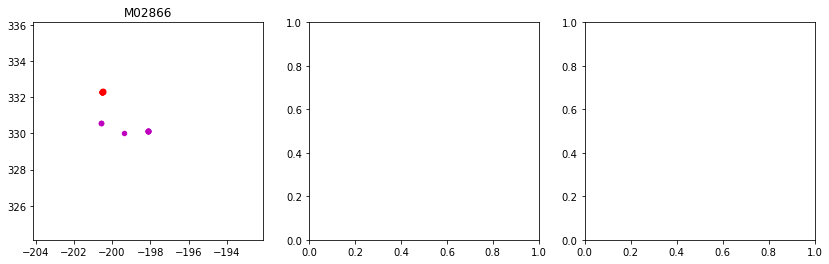

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M02866,0.0000,0.0000,0.0000,0.0000,-5.0000,-8.0000,0.0000,0.0000,9.9900,0.0000,3,21,12,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [20]:
# Here are enabled fibers with poor calib data
sel = enabled&~usable
c = new_cals[sel]
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

M01093 M01525 M01547 M05440 M06238 M07497 M07546 M07754 M07755 M07761 M07913
Plotting 11 fibers


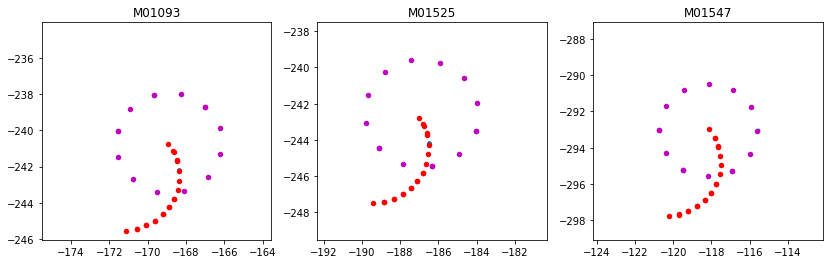

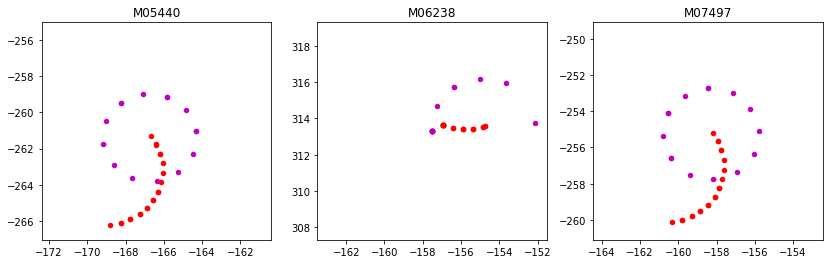

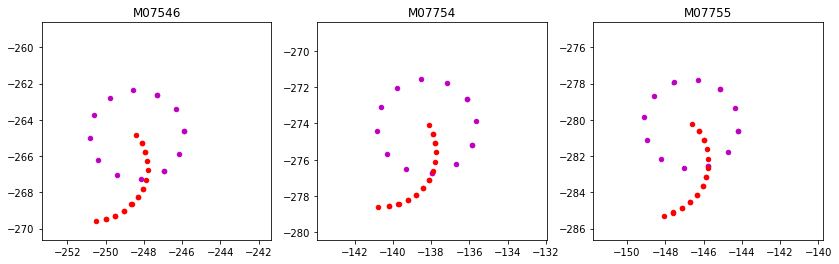

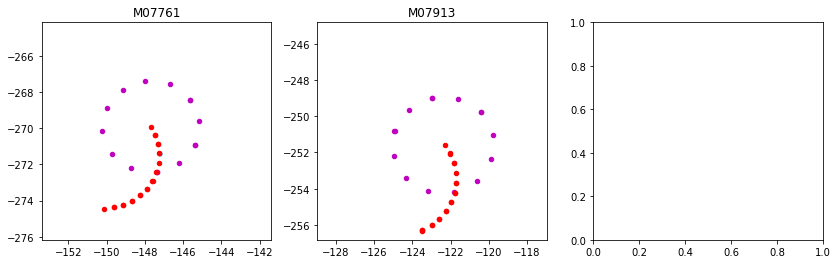

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M01093,3.0901,3.0440,278.2569,95.5698,330.3480,120.7185,0.0123,0.0058,0.0049,0.0051,15,21,0,0,2.7652,126.4180,30.1216,10.0091,0.4206,0.2643,179.7211
1,M01525,3.2935,3.0323,293.9140,86.4813,330.3000,121.5285,0.0102,0.0057,0.0047,0.0042,15,21,0,0,2.9679,124.2224,30.0305,10.1120,0.2253,0.5479,177.7339
2,M01547,2.9369,3.0044,268.0075,167.7945,329.4279,122.4035,0.0098,0.0056,0.0046,0.0040,15,21,0,0,2.5607,128.9528,29.9965,10.2023,0.5201,0.2518,180.3312
3,M05440,2.9695,3.0614,288.7173,113.5949,329.4013,121.3824,0.0099,0.0090,0.0076,0.0041,15,21,0,0,2.4342,132.4194,30.0938,10.1413,0.5176,0.2804,180.4404
4,M06238,3.0778,3.0354,346.3306,50.2731,179.8871,41.9715,0.0019,0.0023,0.0217,0.0020,7,12,8,9,2.7054,127.4712,30.0025,10.1647,0.1993,2.5509,181.0522
5,M07497,3.0118,3.1049,278.2459,113.5833,329.9288,118.8604,0.0127,0.0074,0.0064,0.0055,14,21,0,0,2.5113,131.5486,30.1905,9.9533,8.8468,0.3019,179.1496
6,M07546,3.0251,3.0090,356.9418,68.3905,330.1795,120.4234,0.0105,0.0028,0.0024,0.0043,15,21,0,0,2.4653,131.7729,30.0206,10.0455,0.1682,0.0877,180.3910
7,M07754,2.8913,2.9848,273.1348,140.6859,329.7228,121.7607,0.0103,0.0099,0.0083,0.0042,15,21,0,0,2.6145,127.1911,30.0266,10.1182,0.5187,0.2845,179.4727
8,M07755,2.9800,3.0576,283.5645,140.6758,329.5130,119.7048,0.0143,0.0070,0.0060,0.0059,15,21,0,0,2.4809,131.4971,29.8207,9.9949,0.4116,0.1540,178.9521
9,M07761,2.9607,2.9369,278.2939,131.7022,330.3631,121.4927,0.0127,0.0090,0.0075,0.0052,15,21,0,0,2.5275,129.2482,30.0543,10.1412,0.7368,0.2560,180.0035


In [21]:
# Here are enabled fibers with poor calib data
sel = enabled&~good&usable
c = new_cals[sel]
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

In [22]:
crash_the_kernel()

NameError: name 'crash_the_kernel' is not defined

In [ ]:
# These are fibers that show a large believable offset_xy from the present calibration.
dx = (new_cals['offset_x']-present_cals['offset_x'])*1000
dy = (new_cals['offset_y']-present_cals['offset_y'])*1000
dr = np.sqrt(dx**2+dy**2)
print("Offset_xy:", np.quantile(dr[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
sel = usable&(dr>200)
bad_xy = sel
print(' '.join(list(new_cals['pos_id'][sel])))
c = new_cals[sel]
#print(list(dx[sel]))
#print(list(dy[sel]))
print(list(dr[sel]))
plot_many_fibers(c)
#c.show_in_notebook()
present_cals[sel].show_in_notebook()

In [ ]:
# These are fibers that show a large believable length_r2 change from the present calibration.
dr = (new_cals['length_r2']-present_cals['length_r2'])*1000
print("Length_r2:", np.quantile(dr[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
# Cutting against too few theta points guards against the spiral theta problem
sel2 = (new_cals['arc_p']>35)&(new_cals['rms_p']<0.005)&(new_cals['nfit_t']>14)&(new_cals['err.length_r2']<0.015)
sel = (new_cals['arc_p']>35)&(np.abs(dr)>100)&(new_cals['rms_p']<0.005)&(new_cals['nfit_t']>14)&(new_cals['err.length_r2']<0.015)
sel = usable&(np.abs(dr)>50)
bad_r2 = sel
print(np.sum(sel),"R2 differ by 50 microns\n",' '.join(list(new_cals['pos_id'][sel])))
c = new_cals[sel]
#print(list(dx[sel]))
#print(list(dy[sel]))
#print(list(dr[sel]))
#plot_many_fibers(c)
plt.subplots(1,gridspec_kw=dict(hspace=0.2),figsize=(6,6))
plt.scatter(present_cals['length_r2'][sel2], new_cals['length_r2'][sel2], s=2)
plt.scatter(present_cals['length_r2'][sel], new_cals['length_r2'][sel], s=8, color='r')
plt.xlabel('Present R2',size=16)
plt.ylabel('New R2',size=16)
plt.xlim([2.5,3.5])
plt.ylim([2.5,3.5])
#plt.savefig("arc_r2_comp.png")
plt.show()
#c.show_in_notebook()
#present_cals[sel].show_in_notebook()

In [ ]:
# These are fibers that show a large believable length_r1 change from the present calibration.
dr = (new_cals['length_r1']-present_cals['length_r1'])*1000
print("Length_r1:", np.quantile(dr[usable],[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
# Cutting against too few theta points guards against the spiral theta problem
sel = usable&(np.abs(dr)>50)&~bad_r2&~bad_xy
print(np.sum(sel),"R1 differences, excluding R2 cases\n", ' '.join(list(new_cals['pos_id'][sel])))
c = new_cals[sel]
#print(list(dx[sel]))
#print(list(dy[sel]))
print(list(dr[sel]))
#plot_many_fibers(c)
plt.subplots(1,gridspec_kw=dict(hspace=0.2),figsize=(6,6))
plt.scatter(present_cals['length_r1'][usable&~bad_r2&~bad_xy], new_cals['length_r1'][usable&~bad_r2&~bad_xy], s=2)
plt.scatter(present_cals['length_r1'][sel], new_cals['length_r1'][sel], s=8, color='r')
plt.xlabel('Present R1')
plt.ylabel('New R1')
plt.xlim([2.3,3.5])
plt.ylim([2.3,3.5])
plt.show()
#c.show_in_notebook()
#present_cals[sel].show_in_notebook()

In [ ]:
spirals = ['M01276', 'M01764', 'M03456', 'M03601', 'M03672', 'M03809', 'M04060', 'M07119', 'M07480', 'M07733']
print(' '.join(spirals))
c = Table([spirals])
c.rename_column('col0','pos_id')
plot_many_fibers(c)
spir = (new_cals['offset_x']>1e10)
for s in spirals: spir[pos2idx[s]]='True'

In [ ]:
# These are cases that seemed to hit a hardstop in theta, leaving a partial arc
hardstop = ~broken&~linear_theta&(new_cals['nprune_t']>1)  
#~((new_cals['median_angstep_t']>-15)&(new_cals['median_angstep_t']<0))
c = new_cals[hardstop]
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

In [ ]:
# These are cases that moved ok, but didn't come in far in phi
hard_p = present_cals['offset_p']+present_cals['physical_range_p']
inner_phi = usable&~linear_phi&(new_cals['max_p']<175)&(new_cals['max_p']+13<hard_p)
c = new_cals[inner_phi]
print(' '.join(c['pos_id']))
plot_many_fibers(c)
c.show_in_notebook()

In [ ]:
sky = (present_cals['device_loc']==461)|(present_cals['device_loc']==501)
print(np.sum(sky))
sel = broken&(new_cals['arc_t']<0)&~sky
print(np.sum(sel), np.sum(sel&(present_cals['fiber_intact']==False)))
print("Intact", ' '.join(new_cals['pos_id'][sel&(present_cals['fiber_intact']==True)]))
print('Not intact', ' '.join(new_cals['pos_id'][sel&(present_cals['fiber_intact']==False)]))
#present_cals[sel].show_in_notebook()

In [ ]:
# These are fibers that appear to step correctly in phi, but ended up short,
# probably because of the phi hardstop due to a large non-zero offset_p
print(np.sum(linear_phi), np.sum(linear_phi&(np.abs(new_cals['median_angstep_p']+3)<0.2)))
c=new_cals[linear_phi&(np.abs(new_cals['median_angstep_p']+3)<0.2)]
print(' '.join(c['pos_id']))
#plot_many_fibers(c)
c.show_in_notebook()

Petal location 3
pos_id length_r1 length_r2 offset_x offset_y  arc_t    arc_p   rms_t  rms_p  err.length_r2 err.offset_xy nfit_t nfit_p nprune_t nprune_p theta_arc_radius theta_arc_phi median_angstep_t median_angstep_p rms_angstep_t rms_angstep_p  max_p  
------ --------- --------- -------- -------- -------- -------- ------ ------ ------------- ------------- ------ ------ -------- -------- ---------------- ------------- ---------------- ---------------- ------------- ------------- --------
M03361    3.1572    3.0197 373.3609 149.7613 330.2094 120.7285 0.0032 0.0038        0.0033        0.0013     15     21        0        0           2.6556      129.1349          29.9492          10.0460        0.1467        0.1235 181.1735


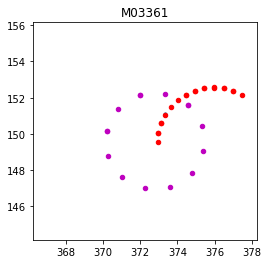

petal_id,device_loc,pos_id,pos_calib_index,time_recorded,bus_id,length_r1,length_r2,offset_x,offset_y,offset_t,offset_p,physical_range_t,physical_range_p,gear_calib_t,gear_calib_p,total_limit_seeks_t,total_limit_seeks_p,last_primary_hardstop_dir_t,last_primary_hardstop_dir_p,keepout_expansion_phi_radial,keepout_expansion_phi_angular,keepout_expansion_theta_radial,keepout_expansion_theta_angular,classified_as_retracted,site,calib_note,fiber_intact,device_classified_nonfunctional
int64,int64,str6,int64,object,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,str4,str97,bool,bool
3,521,M03361,223,2021-06-24 10:21:31.703958+00:00,can16,3.0967,2.9415,373.3791,149.7544,-3.8887,-1.4308,391.7628,211.1858,1.0,1.0,144.0,143.0,-1.0,1.0,0.0,0.0,0.0,0.0,False,kpno,reset_pos_operation_state file=20210623T200048+0000_fp_calibs.ecsv: CLP after recalibrating,True,True


In [24]:
pos_id = 'M03361'
print("Petal location", petal_id2loc[present_cals['petal_id'][pos2idx[pos_id]]])
test_fiber(pos_id)
plot_fiber(pos_id)
present_cals[pos2idx[pos_id]]

In [ ]:
from scipy.spatial import cKDTree

In [ ]:
best_x = np.where(new_cals['offset_x']>0, new_cals['offset_x'], present_cals['offset_x'])
best_y = np.where(new_cals['offset_y']>0, new_cals['offset_y'], present_cals['offset_y'])
use_new = np.where((new_cals['offset_y']>0)&usable_xy, 1,0)


for p in range(2,12):
    sel = (present_cals['petal_id']==p)
    pos_id = present_cals['pos_id'][sel]
    use = use_new[sel]
    tree = cKDTree(np.array(list(zip(best_x[sel],best_y[sel]))))
    dist_mat = tree.sparse_distance_matrix(tree, 12, output_type='ndarray')
    dist_mat = dist_mat[(dist_mat['v']>0)]   # Kill the self matches
    dist_mat = dist_mat[(dist_mat['j']>dist_mat['i'])]   # Kill the pair duplicates
    dist_mat.sort(order=['v'])

    print("\nPetal", petal_id2loc[p], np.quantile(dist_mat['v'], [0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
    for j in range(8):
        print(pos_id[dist_mat['i'][j]], use[dist_mat['i'][j]], pos_id[dist_mat['j'][j]], use[dist_mat['j'][j]], dist_mat['v'][j] )
    print()
    for j in range(-5,0):
        print(pos_id[dist_mat['i'][j]], use[dist_mat['i'][j]], pos_id[dist_mat['j'][j]], use[dist_mat['j'][j]], dist_mat['v'][j] )

    #print("Petal_id",p, dist_mat[:10])
    #print(np.min(dist_mat['v']))



#print(np.sum(np.where(dist_mat==0,0,1)))

# plt.scatter(best_x[sel], best_y[sel], s=4)
# plt.show()